In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [2]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [3]:
NUM_CLASSES = 11

# Dataset reading

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(40, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [8]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 40)                1720      
                                                                 
 dropout_1 (Dropout)         (None, 40)                0         
                                                                 
 dense_1 (Dense)             (None, 30)                1230      
                                                                 
 dense_2 (Dense)             (None, 11)                341       
                                                                 
Total params: 3,291
Trainable params: 3,291
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [11]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
37/63 [================>.............] - ETA: 0s - loss: 2.3714 - accuracy: 0.1309 
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
63/63 [==============================] - 1s 5ms/step - loss: 2.3087 - accuracy: 0.1615 - val_loss: 2.1310 - val_accuracy: 0.2721
Epoch 2/1000
32/63 [==============>...............] - ETA: 0s - loss: 2.1343 - accuracy: 0.2437
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
63/63 [==============================] - 0s 2ms/step - loss: 2.0788 - accuracy: 0.2692 - val_loss: 1.8675 - val_accuracy: 0.3943
Epoch 3/1000
35/63 [===============>..............] - ETA: 0s - loss: 1.9163 - accuracy: 0.3192
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
63/63 [==============================] - 0s 2ms/step - loss: 1.8690 - accuracy: 0.3310 - val_loss: 1.5844 - val_accuracy: 0.5162
Epoch 4/1000
36/63 [================>.............] - ETA: 0s - loss: 1.7300 - accuracy: 0.3763


38/63 [=================>............] - ETA: 0s - loss: 0.9426 - accuracy: 0.6680
Epoch 28: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
63/63 [==============================] - 0s 2ms/step - loss: 0.9331 - accuracy: 0.6722 - val_loss: 0.4340 - val_accuracy: 0.9279
Epoch 29/1000
39/63 [=================>............] - ETA: 0s - loss: 0.9192 - accuracy: 0.6657
Epoch 29: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
63/63 [==============================] - 0s 2ms/step - loss: 0.9211 - accuracy: 0.6657 - val_loss: 0.4206 - val_accuracy: 0.9211
Epoch 30/1000
39/63 [=================>............] - ETA: 0s - loss: 0.8986 - accuracy: 0.6723
Epoch 30: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
63/63 [==============================] - 0s 2ms/step - loss: 0.9074 - accuracy: 0.6704 - val_loss: 0.4207 - val_accuracy: 0.9343
Epoch 31/1000
38/63 [=================>............] - ETA: 0s - loss: 0.9000 - accuracy: 0.6776
Epoch 31

61/63 [============================>.] - ETA: 0s - loss: 0.7597 - accuracy: 0.7295
Epoch 55: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
63/63 [==============================] - 0s 3ms/step - loss: 0.7584 - accuracy: 0.7299 - val_loss: 0.3072 - val_accuracy: 0.9502
Epoch 56/1000
38/63 [=================>............] - ETA: 0s - loss: 0.7539 - accuracy: 0.7321
Epoch 56: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
63/63 [==============================] - 0s 2ms/step - loss: 0.7661 - accuracy: 0.7265 - val_loss: 0.3052 - val_accuracy: 0.9574
Epoch 57/1000
37/63 [================>.............] - ETA: 0s - loss: 0.7583 - accuracy: 0.7215
Epoch 57: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
63/63 [==============================] - 0s 2ms/step - loss: 0.7654 - accuracy: 0.7225 - val_loss: 0.3123 - val_accuracy: 0.9506
Epoch 58/1000
36/63 [================>.............] - ETA: 0s - loss: 0.7628 - accuracy: 0.7174
Epoch 58

36/63 [================>.............] - ETA: 0s - loss: 0.6639 - accuracy: 0.7622
Epoch 82: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
63/63 [==============================] - 0s 2ms/step - loss: 0.6742 - accuracy: 0.7601 - val_loss: 0.2752 - val_accuracy: 0.9570
Epoch 83/1000
38/63 [=================>............] - ETA: 0s - loss: 0.6625 - accuracy: 0.7564
Epoch 83: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
63/63 [==============================] - 0s 2ms/step - loss: 0.6700 - accuracy: 0.7547 - val_loss: 0.2639 - val_accuracy: 0.9642
Epoch 84/1000
38/63 [=================>............] - ETA: 0s - loss: 0.6824 - accuracy: 0.7477
Epoch 84: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
63/63 [==============================] - 0s 2ms/step - loss: 0.6772 - accuracy: 0.7537 - val_loss: 0.2797 - val_accuracy: 0.9604
Epoch 85/1000
37/63 [================>.............] - ETA: 0s - loss: 0.6613 - accuracy: 0.7555
Epoch 85

In [12]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

21/21 [==============================] - 0s 1ms/step - loss: 0.2601 - accuracy: 0.9547


In [13]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xfc in position 54: invalid start byte

In [14]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 66ms/step
[9.2296340e-02 2.8818650e-03 6.8014931e-05 3.7426790e-03 1.2984208e-03
 5.7799768e-01 3.0787012e-01 1.4603952e-09 2.3383858e-05 1.8104493e-10
 1.3821572e-02]
5


# Confusion matrix

83/83 [==============================] - 0s 738us/step


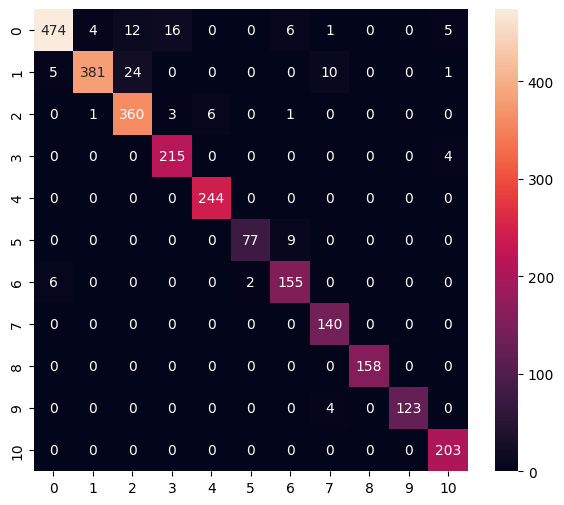

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       518
           1       0.99      0.90      0.94       421
           2       0.91      0.97      0.94       371
           3       0.92      0.98      0.95       219
           4       0.98      1.00      0.99       244
           5       0.97      0.90      0.93        86
           6       0.91      0.95      0.93       163
           7       0.90      1.00      0.95       140
           8       1.00      1.00      1.00       158
           9       1.00      0.97      0.98       127
          10       0.95      1.00      0.98       203

    accuracy                           0.95      2650
   macro avg       0.96      0.96      0.96      2650
weighted avg       0.96      0.95      0.95      2650



In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [16]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [17]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\imran\AppData\Local\Temp\tmpggwy3ji4\assets


INFO:tensorflow:Assets written to: C:\Users\imran\AppData\Local\Temp\tmpggwy3ji4\assets


6744

# Inference test

In [18]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [19]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [20]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [21]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 3 ms


In [22]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[9.41281319e-02 2.94028921e-03 6.84912811e-05 3.64218699e-03
 1.33001851e-03 5.75184584e-01 3.08960617e-01 1.49955415e-09
 2.41014695e-05 1.86818311e-10 1.37216095e-02]
5
